# MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


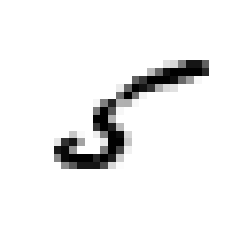

5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[11]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print(y[11])

In [4]:
import numpy as np
y = y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_classifer = SGDClassifier(random_state=42)
sgd_classifer.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_classifer.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_classifer)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9701
0.9614
0.9586


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifer, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_classifier = Never5Classifier()
cross_val_score(never_5_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifer, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == TP / (TP + FP)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred) # == TP / (TP + FN)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [20]:
y_scores = sgd_classifer.decision_function([some_digit])
y_scores

array([4742.52813158])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # True Positive, When Threshold = 0

array([ True])

In [22]:
threshold = 8000 # Raise the Threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # False Negative, When Threshold = 8000

array([False])

In [23]:
y_scores = cross_val_predict(sgd_classifer, X_train, y_train_5, cv=3, method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

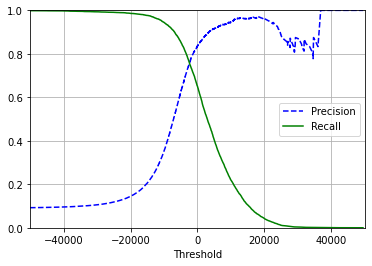

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalles, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalles[:-1], 'g-', label='Recall')
    plt.legend(loc="center right")
    plt.xlabel("Threshold")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


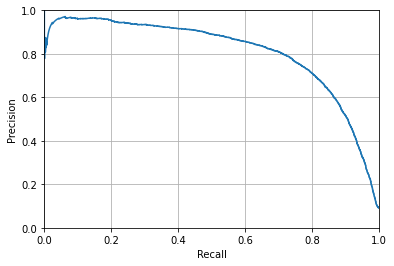

In [27]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [30]:
# We use this code to make prediction instead of predict()
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
# Let's check precision and recall for these predictions
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

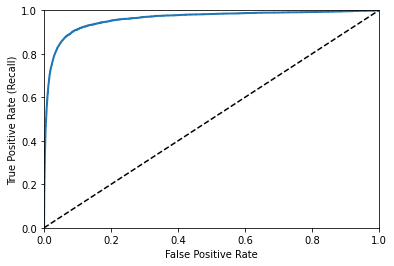

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    
plot_roc_curve(fpr, tpr)

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Compare RandomForestClassifier with SGDClassifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [39]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

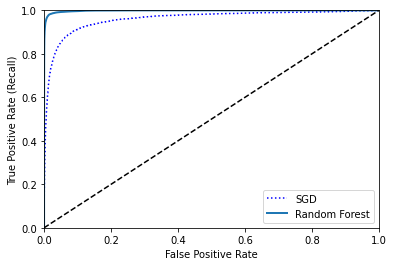

In [40]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [102]:
sgd_classifer.fit(X_train, y_train)
sgd_classifer.predict([some_digit])

array([5], dtype=uint8)

In [103]:
some_digit_scores = sgd_classifer.decision_function([some_digit])
some_digit_scores

array([[-30446.28807622, -20771.5971377 ,  -4069.97324426,
         -7297.18084344,  -2335.35560779,   3839.63697115,
        -27845.48223256, -11660.53889926,   -540.54962964,
        -11918.2854924 ]])

In [104]:
np.argmax(some_digit_scores)

5

In [106]:
sgd_classifer.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [107]:
sgd_classifer.classes_[5]

5

In [112]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [113]:
len(ovo_clf.estimators_)

45

In [115]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.91545, 0.9131 , 0.92045])

# Error Analysis

In [127]:
y_train_pred = cross_val_predict(ovo_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5741,    1,   26,   13,    7,   48,   51,    7,   23,    6],
       [   3, 6524,   35,   31,    9,   15,    2,   18,   91,   14],
       [  38,   50, 5414,  108,   78,   22,   68,   54,  112,   14],
       [  20,   21,  141, 5462,    8,  206,   10,   45,  183,   35],
       [  17,   14,   48,    3, 5377,   17,   50,   24,   38,  254],
       [  78,   10,   45,  278,   33, 4700,   75,    5,  156,   41],
       [  56,    6,   56,    5,   58,  101, 5588,    3,   45,    0],
       [  14,   21,   56,   47,   52,   12,    3, 5746,   33,  281],
       [  41,   76,   88,  245,   17,  238,   32,   19, 5041,   54],
       [  25,   22,   18,   66,  143,   38,    3,  175,   72, 5387]],
      dtype=int64)

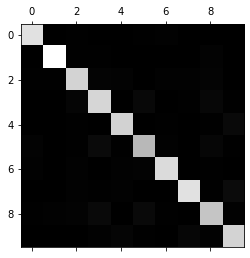

In [128]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [129]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

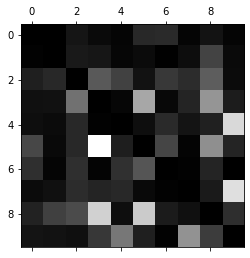

In [130]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [132]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [133]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [134]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# Multioutput Classification

In [135]:
noise = np.random.randint(0, 100,(len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100,(len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

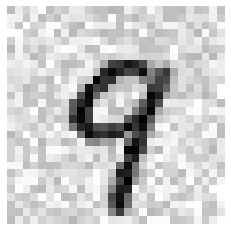

In [147]:
some_digit_mod = X_test_mod[12]
some_digit_image_mod = some_digit_mod.reshape(28, 28)

plt.imshow(some_digit_image_mod, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [144]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [148]:
clean_digit = knn_clf.predict([X_test_mod[12]])

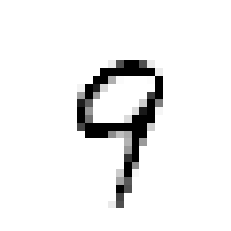

In [149]:
clean_digit_image_mod = clean_digit.reshape(28, 28)

plt.imshow(clean_digit_image_mod, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()